# Reproducibility and risk audit

## Preperation

In [1]:
# Install all required packages

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import re, sys, os

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import nltk
from nltk.corpus import stopwords

import textblob 
from textblob import Word
from textblob import TextBlob

from scipy import stats
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud 

from collections import Counter

In [2]:
# Get the dataset into the computational environment

df = pd.read_excel('Data.xlsx', sheet_name='Consoilidated')

In [4]:
# This block checks to ensure that all the columns in the uploaded datasheet are as expected
# Proceed with the analysis if there is no error
# If there is an error, follow the instructions in the error message

expected_cols = ['Person', 'Day', 'Date ', 'Sleep (hours)', 'Sleep (minutes)'
                 , 'Minutes of sleep', 'Sleep Quality (1 Very Bad - 5 Very Good)'
                 , 'How many times did you wake up during the night'
                 , 'Wakeup Time (HH:MM)', 'Bedtime (HH:MM)(night before)'
                 , 'Did you nap during the day (yes/ no)', 'Steps', 'KM'
                 , 'Any physical activity not recorded by health app (yes/no) (such as swiming)'
                 , 'Description of mood/experience during day. No word limit. Free text .'
                 , 'Personal Expenses']

provided_cols = list(df)

if provided_cols != expected_cols:
    raise ValueError('Expected data file column headers do not match with the provided data file column headers.\n'
    'Check if the all the columns are present in the uploaded dataset and in order :\n'
    f'{expected_cols}')

In [5]:
# Convert the 'Day' as ordered, for the ease of sorting in the plots

cats_day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df['Day'] = df['Day'].astype(CategoricalDtype(categories=cats_day, ordered=True))

In [6]:
# Convert type of 'Date' column to 'Datetime' ensure that all packages work without any issues

df['Date '] = pd.to_datetime(df['Date ']).apply(lambda x: x.date())

In [7]:
# Convert sleep quality from float to int as all the values represent different bands

df['Sleep Quality (1 Very Bad - 5 Very Good)'] = df['Sleep Quality (1 Very Bad - 5 Very Good)'].fillna(0)
df['Sleep Quality (1 Very Bad - 5 Very Good)'] = df['Sleep Quality (1 Very Bad - 5 Very Good)'].astype(int)

In [8]:
# Fill up the empty rows of mood/experience column with ' ' 

df['Description of mood/experience during day. No word limit. Free text .'] = df['Description of mood/experience during day. No word limit. Free text .'].fillna(' ')

## Analysis of dataset
### Sleep analysis

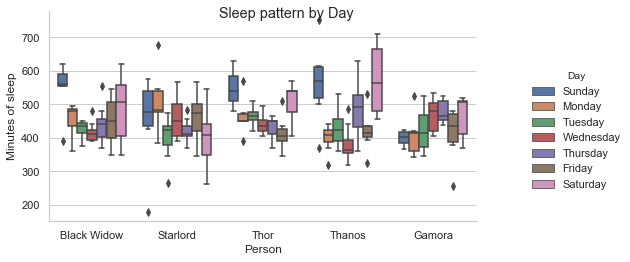

In [9]:
# Visualize the sleep pattern of the participants by day of the week using the seaborn's box plot
# The graph represents the distribution of sleep time for every participant over the days of the week during the entire project duration
# Function to plot graph available in /my_utils/viz_utils.py

from my_utils.viz_utils import plot_1

plot_1('Person', 'Minutes of sleep', 'box', 'Day', df)

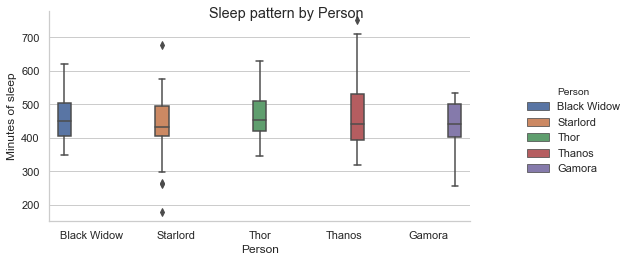

In [10]:
# The graph represents the distribution of sleep time for every participant over the period of studies

plot_1('Person', 'Minutes of sleep', 'box', 'Person', df)

## Sentiment Analysis

In this section, the sentiment scores are derived are using the python package Sentiment Vader.
https://github.com/cjhutto/vaderSentiment  
It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains as well.

In [11]:
# Import the requirements and create the analyser object

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [12]:
# Function to calculate the sentiment score for a sentence

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [13]:
# Get sentiment score for each comments entered by the participants

df['VADER_SCORE'] = df['Description of mood/experience during day. No word limit. Free text .'].apply(sentiment_analyzer_scores)

In [14]:
# Convert the sentiment scores to easily usable format 
# Iterate over the dictionary and append the values to the created features

df_dict_to_series = df['VADER_SCORE'].apply(pd.Series)
df = df.join(df_dict_to_series)
del df_dict_to_series
df = df.drop(columns='VADER_SCORE')

In [15]:
# Function to categorize the sentiment bands based on info from github source
# Scores greaterr that 0.05 are positive, less than -0.05 are negative and remaining are neutral

def sent_band(val):

    if val >= 0.05:
        band = 'Positive'
    elif val <= -0.05:
        band = 'Negative'
    else:
        band = 'Neutral'
    
    return band

In [16]:
# Get sentiment band for each comments entered by the participants

df['sentiment_band'] = df['compound'].apply(lambda x: sent_band(x))

In [19]:
# Run this block only if required
# Write the pandas dataframe with to a csv file which can then be used for further analysis in any data visualization tool like tableau, power BI, etc.

df.to_csv('processed_data.csv')